# Classificador de draft da NBA
O objetivo do modelo é, a partir dos dados das temporadas 1996-97 a 2021-22, classificar corretamente se o jogador é *undrafted*, ou seja, não foi draftado.

Passo a passo:
* Escolha do problema ✔
* Separação dos dados em treino, validação e teste ✔
* Selecionar algoritmos para resolver o problema ✔
* Adicionar MLFlow no treinamento dos modelos ✔
* Executar uma ferramenta de seleção de hiper-parâmetros ✔
* Realizar diagnóstico do melhor modelo e tentar melhorá-lo a partir disso ✔

## Dependências

In [ ]:
!pip install mlflow
!pip install optuna

In [14]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import mlflow
import mlflow.sklearn
from urllib.parse import urlparse
import optuna

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Carregando o dataset

In [5]:
# Path Tales
path = '/content/drive/MyDrive/2022.1/TA GDI/projeto1/data/classification.csv'

In [6]:
dataset = pd.read_csv(path)

In [7]:
dataset.head()

,player_name,team_abbreviation,age,player_height,player_weight,college,country,draft_year,draft_round,draft_number,...,oreb_pct,dreb_pct,usg_pct,ts_pct,ast_pct,season,undrafted,season_start_year,season_end_year,gp_pct
0,2071,16,0.153846,0.750000,0.485714,65,72,0.568966,0.125,0.175758,...,0.127,0.182,0.142,0.536,0.052,0,0.0,0.0,0.0,0.865854
1,1475,13,0.461538,0.678571,0.485714,117,72,NaN,NaN,NaN,...,0.016,0.115,0.151,0.535,0.099,0,1.0,0.0,0.0,0.865854
2,1466,2,0.423077,0.714286,0.533333,227,72,NaN,NaN,NaN,...,0.083,0.152,0.167,0.542,0.101,0,1.0,0.0,0.0,0.902439
3,1465,9,0.153846,0.642857,0.485714,189,72,0.568966,0.125,0.151515,...,0.109,0.118,0.233,0.482,0.114,0,0.0,0.0,0.0,0.512195
4,1464,35,0.153846,0.535714,0.438095,249,72,0.551724,0.250,0.303030,...,0.087,0.045,0.135,0.470,0.125,0,0.0,0.0,0.0,0.109756


In [8]:
dataset.groupby(['undrafted'])['player_name'].count()

undrafted
0.0    9629
1.0    1875
Name: player_name, dtype: int64

Como podemos observar, nosso dataset é desbalanceado com relação a categoria 'undrafted'.

## Separação dos conjuntos de treino, validação e teste

In [9]:
RANDOM_STATE = 42

In [10]:
dataset.columns

Index(['player_name', 'team_abbreviation', 'age', 'player_height',
       'player_weight', 'college', 'country', 'draft_year', 'draft_round',
       'draft_number', 'gp', 'pts', 'reb', 'ast', 'net_rating', 'oreb_pct',
       'dreb_pct', 'usg_pct', 'ts_pct', 'ast_pct', 'season', 'undrafted',
       'season_start_year', 'season_end_year', 'gp_pct'],
      dtype='object')

Escolhemos as colunas de altura, peso, faculdade, país, jogos realizados e métricas de desempenho (pts, reb, ast...) para compor o conjunto de features e a coluna 'undrafted' é nossa label

In [11]:
X = dataset[['player_height', 'player_weight', 'college', 'country', 
             'gp', 'pts', 'reb', 'ast', 'net_rating', 'oreb_pct',
             'dreb_pct', 'usg_pct', 'ts_pct', 'ast_pct']]
y = dataset['undrafted']
X.shape, y.shape

((11504, 14), (11504,))

Designamos 70% dos dados para treino, 20% para teste e 10% para validação

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125, random_state=RANDOM_STATE)

X_train.shape, X_val.shape, X_test.shape

((8052, 14), (1151, 14), (2301, 14))

## Seleção de algoritmos
Selecionamos os seguintes para resolução do problema de classificação:
* MLP
* RandomForest
* XGBoost
* LogisticRegression

Ademais, como notamos que o dataset é bem desbalanceado, utilizaremos o f1 score como métrica principal na validação, além de AUROC e accuracy.

In [13]:
def eval_metrics(y_true, y_pred, y_proba):
  f1 = f1_score(y_true, y_pred, average='weighted')
  acc = accuracy_score(y_true, y_pred)
  auroc = roc_auc_score(y_true, y_proba[:, 1])
  return acc, auroc, f1

### MLPs
No algoritmo MLP, vamos variar os parâmetros `hidden_layer_sizes` (número de neurônios nas camadas escondidas), `activation` (função de ativação dos neurônios) e `solver` que otimiza a atualização dos pesos.

In [ ]:
EPOCHS=1000

#### Tentativa 1

In [ ]:
hidden_layer_sizes=(100,)
activation='relu'
solver='adam'

In [ ]:
with mlflow.start_run():
  mlp = MLPClassifier(random_state=RANDOM_STATE, max_iter=EPOCHS, hidden_layer_sizes=hidden_layer_sizes, activation=activation, solver=solver)
  mlp.fit(X_train, y_train)

  y_pred = mlp.predict(X_val)
  y_proba = mlp.predict_proba(X_val)

  (acc, auroc, f1) = eval_metrics(y_val, y_pred, y_proba)

  mlflow.log_param("hidden_layer_sizes", hidden_layer_sizes)
  mlflow.log_param("activation", activation)
  mlflow.log_param("solver", solver)
  mlflow.log_metric("accuracy", acc)
  mlflow.log_metric("auroc", auroc)
  mlflow.log_metric("f1", f1)

  tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme

  # Model registry does not work with file store
  if tracking_url_type_store != "file":
    # Register the model
    # There are other ways to use the Model Registry, which depends on the use case,
    # please refer to the doc for more information:
    # https://mlflow.org/docs/latest/model-registry.html#api-workflow
    mlflow.sklearn.log_model(mlp, "model", registered_model_name="MLP_NBA_Undrafted")
  else:
    mlflow.sklearn.log_model(mlp, "model")

In [ ]:
!less /content/mlruns/0/b5f8ad22854f4b568521073bda44aa34/params/activation

relu
>8

In [ ]:
!less /content/mlruns/0/b5f8ad22854f4b568521073bda44aa34/params/hidden_layer_sizes

(100,)
>8

In [ ]:
!less /content/mlruns/0/b5f8ad22854f4b568521073bda44aa34/params/solver

adam
>8

In [ ]:
!less /content/mlruns/0/b5f8ad22854f4b568521073bda44aa34/metrics/auroc

1662078783968 0.7446037229928325 0
>8

In [ ]:
!less /content/mlruns/0/b5f8ad22854f4b568521073bda44aa34/metrics/f1

1662078783970 0.754230082735617 0
>8

In [ ]:
!less /content/mlruns/0/b5f8ad22854f4b568521073bda44aa34/metrics/accuracy

1662078783967 0.8201563857515204 0
>8

#### Tentativa 2


```
hidden_layers = (10,10)
```



In [ ]:
hidden_layer_sizes=(10, 10)
activation='relu'
solver='adam'

In [ ]:
with mlflow.start_run():
  mlp = MLPClassifier(random_state=RANDOM_STATE, max_iter=EPOCHS, hidden_layer_sizes=hidden_layer_sizes, activation=activation, solver=solver)
  mlp.fit(X_train, y_train)

  y_pred = mlp.predict(X_val)
  y_proba = mlp.predict_proba(X_val)

  (acc, auroc, f1) = eval_metrics(y_val, y_pred, y_proba)

  mlflow.log_param("hidden_layer_sizes", hidden_layer_sizes)
  mlflow.log_param("activation", activation)
  mlflow.log_param("solver", solver)
  mlflow.log_metric("accuracy", acc)
  mlflow.log_metric("auroc", auroc)
  mlflow.log_metric("f1", f1)

  tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme

  # Model registry does not work with file store
  if tracking_url_type_store != "file":
    # Register the model
    # There are other ways to use the Model Registry, which depends on the use case,
    # please refer to the doc for more information:
    # https://mlflow.org/docs/latest/model-registry.html#api-workflow
    mlflow.sklearn.log_model(mlp, "model", registered_model_name="MLP_NBA_Undrafted")
  else:
    mlflow.sklearn.log_model(mlp, "model")

In [ ]:
!cat /content/mlruns/0/dac45b74013a437bae0dfae8d95fe6f1/params/activation

relu

In [ ]:
!cat /content/mlruns/0/dac45b74013a437bae0dfae8d95fe6f1/params/hidden_layer_sizes

(10, 10)

In [ ]:
!cat /content/mlruns/0/dac45b74013a437bae0dfae8d95fe6f1/params/solver

adam

In [ ]:
!cat /content/mlruns/0/dac45b74013a437bae0dfae8d95fe6f1/metrics/auroc

1662078957608 0.7428969215696385 0


In [ ]:
!cat /content/mlruns/0/dac45b74013a437bae0dfae8d95fe6f1/metrics/f1

1662078957610 0.7431908403435481 0


In [ ]:
!cat /content/mlruns/0/dac45b74013a437bae0dfae8d95fe6f1/metrics/accuracy

1662078957607 0.8218940052128584 0


#### Tentativa 3

```
hidden_layers = (10,10)
activation = 'logistic'
solver = 'sgd'
```




In [ ]:
hidden_layer_sizes=(10, 10)
activation='logistic'
solver='sgd'

In [ ]:
with mlflow.start_run():
  mlp = MLPClassifier(random_state=RANDOM_STATE, max_iter=EPOCHS, hidden_layer_sizes=hidden_layer_sizes, activation=activation, solver=solver)
  mlp.fit(X_train, y_train)

  y_pred = mlp.predict(X_val)
  y_proba = mlp.predict_proba(X_val)

  (acc, auroc, f1) = eval_metrics(y_val, y_pred, y_proba)

  mlflow.log_param("hidden_layer_sizes", hidden_layer_sizes)
  mlflow.log_param("activation", activation)
  mlflow.log_param("solver", solver)
  mlflow.log_metric("accuracy", acc)
  mlflow.log_metric("auroc", auroc)
  mlflow.log_metric("f1", f1)

  tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme

  # Model registry does not work with file store
  if tracking_url_type_store != "file":
    # Register the model
    # There are other ways to use the Model Registry, which depends on the use case,
    # please refer to the doc for more information:
    # https://mlflow.org/docs/latest/model-registry.html#api-workflow
    mlflow.sklearn.log_model(mlp, "model", registered_model_name="MLP_NBA_Undrafted")
  else:
    mlflow.sklearn.log_model(mlp, "model")

In [ ]:
!cat /content/mlruns/0/c3f5c69195704f6f80d3a0b0c326c97d/params/activation

logistic

In [ ]:
!cat /content/mlruns/0/c3f5c69195704f6f80d3a0b0c326c97d/params/hidden_layer_sizes

(10, 10)

In [ ]:
!cat /content/mlruns/0/c3f5c69195704f6f80d3a0b0c326c97d/params/solver

sgd

In [ ]:
!cat /content/mlruns/0/c3f5c69195704f6f80d3a0b0c326c97d/metrics/auroc

1662079054027 0.48951683597174234 0


In [ ]:
!cat /content/mlruns/0/c3f5c69195704f6f80d3a0b0c326c97d/metrics/f1

1662079054028 0.7415467133346342 0


In [ ]:
!cat /content/mlruns/0/c3f5c69195704f6f80d3a0b0c326c97d/metrics/accuracy

1662079054025 0.8218940052128584 0


### LogisticRegression
No algoritmo LogisticRegression, variaremos os parâmetros `penalty` (especifica a norma da penalidade) e `solver` (especifica o algoritmo de otimização).

#### Tentativa 1


```
penalty = 'l2'
solver = 'liblinear'
```



In [ ]:
penalty = 'l2'
solver = 'liblinear'

In [ ]:
with mlflow.start_run():
  lr = LogisticRegression(random_state=RANDOM_STATE, penalty=penalty, solver=solver)
  lr.fit(X_train, y_train)

  y_pred = lr.predict(X_val)
  y_proba = lr.predict_proba(X_val)

  (acc, auroc, f1) = eval_metrics(y_val, y_pred, y_proba)

  mlflow.log_param("penalty", penalty)
  mlflow.log_param("solver", solver)
  mlflow.log_metric("accuracy", acc)
  mlflow.log_metric("auroc", auroc)
  mlflow.log_metric("f1", f1)

  tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme

  # Model registry does not work with file store
  if tracking_url_type_store != "file":
    # Register the model
    # There are other ways to use the Model Registry, which depends on the use case,
    # please refer to the doc for more information:
    # https://mlflow.org/docs/latest/model-registry.html#api-workflow
    mlflow.sklearn.log_model(lr, "model", registered_model_name="LR_NBA_Undrafted")
  else:
    mlflow.sklearn.log_model(lr, "model")

In [ ]:
!cat /content/mlruns/0/8fe01fc13e704af8befc92a1931e42e2/params/penalty

l2

In [ ]:
!cat /content/mlruns/0/8fe01fc13e704af8befc92a1931e42e2/params/solver

liblinear

In [ ]:
!cat /content/mlruns/0/8fe01fc13e704af8befc92a1931e42e2/metrics/auroc

1662120201332 0.7512246686948899 0


In [ ]:
!cat /content/mlruns/0/8fe01fc13e704af8befc92a1931e42e2/metrics/f1

1662120201334 0.7538235059016244 0


In [ ]:
!cat /content/mlruns/0/8fe01fc13e704af8befc92a1931e42e2/metrics/accuracy

1662120201331 0.8218940052128584 0


#### Tentativa 2

```
penalty = 'l1'
solver = 'saga'
```



In [ ]:
penalty = 'l1'
solver = 'saga'

In [ ]:
with mlflow.start_run():
  lr = LogisticRegression(random_state=RANDOM_STATE, penalty=penalty, solver=solver)
  lr.fit(X_train, y_train)

  y_pred = lr.predict(X_val)
  y_proba = lr.predict_proba(X_val)

  (acc, auroc, f1) = eval_metrics(y_val, y_pred, y_proba)

  mlflow.log_param("penalty", penalty)
  mlflow.log_param("solver", solver)
  mlflow.log_metric("accuracy", acc)
  mlflow.log_metric("auroc", auroc)
  mlflow.log_metric("f1", f1)

  tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme

  # Model registry does not work with file store
  if tracking_url_type_store != "file":
    # Register the model
    # There are other ways to use the Model Registry, which depends on the use case,
    # please refer to the doc for more information:
    # https://mlflow.org/docs/latest/model-registry.html#api-workflow
    mlflow.sklearn.log_model(lr, "model", registered_model_name="LR_NBA_Undrafted")
  else:
    mlflow.sklearn.log_model(lr, "model")

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


In [ ]:
!cat /content/mlruns/0/0139f9f8834842c7bbb0421e078e6e5b/params/penalty

l1

In [ ]:
!cat /content/mlruns/0/0139f9f8834842c7bbb0421e078e6e5b/params/solver

saga

In [ ]:
!cat /content/mlruns/0/0139f9f8834842c7bbb0421e078e6e5b/metrics/auroc

1662120389437 0.663234156654463 0


In [ ]:
!cat /content/mlruns/0/0139f9f8834842c7bbb0421e078e6e5b/metrics/f1

1662120389438 0.7415467133346342 0


In [ ]:
!cat /content/mlruns/0/0139f9f8834842c7bbb0421e078e6e5b/metrics/accuracy

1662120389436 0.8218940052128584 0


#### Tentativa 3

```
penalty = 'elasticnet'
solver = 'saga'
```



In [ ]:
penalty = 'elasticnet'
solver = 'saga'

In [ ]:
with mlflow.start_run():
  lr = LogisticRegression(random_state=RANDOM_STATE, penalty=penalty, solver=solver, l1_ratio=0.5, max_iter=1000)
  lr.fit(X_train, y_train)

  y_pred = lr.predict(X_val)
  y_proba = lr.predict_proba(X_val)

  (acc, auroc, f1) = eval_metrics(y_val, y_pred, y_proba)

  mlflow.log_param("penalty", penalty)
  mlflow.log_param("solver", solver)
  mlflow.log_metric("accuracy", acc)
  mlflow.log_metric("auroc", auroc)
  mlflow.log_metric("f1", f1)

  tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme

  # Model registry does not work with file store
  if tracking_url_type_store != "file":
    # Register the model
    # There are other ways to use the Model Registry, which depends on the use case,
    # please refer to the doc for more information:
    # https://mlflow.org/docs/latest/model-registry.html#api-workflow
    mlflow.sklearn.log_model(lr, "model", registered_model_name="LR_NBA_Undrafted")
  else:
    mlflow.sklearn.log_model(lr, "model")

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


In [ ]:
!cat /content/mlruns/0/253e4d2f20f24254a7fc2d693159bfc1/params/penalty

elasticnet

In [ ]:
!cat /content/mlruns/0/253e4d2f20f24254a7fc2d693159bfc1/params/solver

saga

In [ ]:
!cat /content/mlruns/0/253e4d2f20f24254a7fc2d693159bfc1/metrics/auroc

1662120583300 0.709585933068633 0


In [ ]:
!cat /content/mlruns/0/253e4d2f20f24254a7fc2d693159bfc1/metrics/f1

1662120583302 0.7415467133346342 0


In [ ]:
!cat /content/mlruns/0/253e4d2f20f24254a7fc2d693159bfc1/metrics/accuracy

1662120583299 0.8218940052128584 0


### RandomForestClassifier
No algoritmo RandomForest, decidimos acompanhar a variação dos parâmetros `n_estimators` (número de árvores na floresta), `criterion` (função que mede a qualidade da separação) e `max_depth` (altera a profundidade máxima das árvores).

#### Tentativa 1

```
n_estimators = 100
criterion = 'gini'
max_depth = None
```



In [ ]:
n_estimators = 100
criterion = 'gini'
max_depth = None

In [ ]:
with mlflow.start_run():
  rf = RandomForestClassifier(random_state=RANDOM_STATE, n_estimators=n_estimators, criterion=criterion, max_depth=max_depth)
  rf.fit(X_train, y_train)

  y_pred = rf.predict(X_val)
  y_proba = rf.predict_proba(X_val)

  (acc, auroc, f1) = eval_metrics(y_val, y_pred, y_proba)

  mlflow.log_param("n_estimators", n_estimators)
  mlflow.log_param("criterion", criterion)
  mlflow.log_param("max_depth", max_depth)
  mlflow.log_metric("accuracy", acc)
  mlflow.log_metric("auroc", auroc)
  mlflow.log_metric("f1", f1)

  tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme

  # Model registry does not work with file store
  if tracking_url_type_store != "file":
    # Register the model
    # There are other ways to use the Model Registry, which depends on the use case,
    # please refer to the doc for more information:
    # https://mlflow.org/docs/latest/model-registry.html#api-workflow
    mlflow.sklearn.log_model(rf, "model", registered_model_name="RF_NBA_Undrafted")
  else:
    mlflow.sklearn.log_model(rf, "model")

In [ ]:
!cat /content/mlruns/0/c3e9d3f5601c4cdabc0a4f0ba49e2541/params/n_estimators

100

In [ ]:
!cat /content/mlruns/0/c3e9d3f5601c4cdabc0a4f0ba49e2541/params/criterion

gini

In [ ]:
!cat /content/mlruns/0/c3e9d3f5601c4cdabc0a4f0ba49e2541/params/max_depth

None

In [ ]:
!cat /content/mlruns/0/c3e9d3f5601c4cdabc0a4f0ba49e2541/metrics/auroc

1662121124478 0.8366240396019182 0


In [ ]:
!cat /content/mlruns/0/c3e9d3f5601c4cdabc0a4f0ba49e2541/metrics/f1

1662121124479 0.7826776956198876 0


In [ ]:
!cat /content/mlruns/0/c3e9d3f5601c4cdabc0a4f0ba49e2541/metrics/accuracy

1662121124478 0.8340573414422241 0


#### Tentativa 2

```
n_estimators = 200
criterion = 'gini'
max_depth = None
```



In [ ]:
n_estimators = 200
criterion = 'gini'
max_depth = None

In [ ]:
with mlflow.start_run():
  rf = RandomForestClassifier(random_state=RANDOM_STATE, n_estimators=n_estimators, criterion=criterion, max_depth=max_depth)
  rf.fit(X_train, y_train)

  y_pred = rf.predict(X_val)
  y_proba = rf.predict_proba(X_val)

  (acc, auroc, f1) = eval_metrics(y_val, y_pred, y_proba)

  mlflow.log_param("n_estimators", n_estimators)
  mlflow.log_param("criterion", criterion)
  mlflow.log_param("max_depth", max_depth)
  mlflow.log_metric("accuracy", acc)
  mlflow.log_metric("auroc", auroc)
  mlflow.log_metric("f1", f1)

  tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme

  # Model registry does not work with file store
  if tracking_url_type_store != "file":
    # Register the model
    # There are other ways to use the Model Registry, which depends on the use case,
    # please refer to the doc for more information:
    # https://mlflow.org/docs/latest/model-registry.html#api-workflow
    mlflow.sklearn.log_model(rf, "model", registered_model_name="RF_NBA_Undrafted")
  else:
    mlflow.sklearn.log_model(rf, "model")

In [ ]:
!cat /content/mlruns/0/37399a681ba84856928153aacde4623d/params/n_estimators

200

In [ ]:
!cat /content/mlruns/0/37399a681ba84856928153aacde4623d/params/criterion

gini

In [ ]:
!cat /content/mlruns/0/37399a681ba84856928153aacde4623d/params/max_depth

None

In [ ]:
!cat /content/mlruns/0/37399a681ba84856928153aacde4623d/metrics/auroc

1662121391197 0.8431702160573403 0


In [ ]:
!cat /content/mlruns/0/37399a681ba84856928153aacde4623d/metrics/f1

1662121391198 0.7866288627891993 0


In [ ]:
!cat /content/mlruns/0/37399a681ba84856928153aacde4623d/metrics/accuracy

1662121391197 0.8366637706342311 0


#### Tentativa 3

```
n_estimators = 200
criterion = 'entropy'
max_depth = 15
```



In [ ]:
n_estimators = 200
criterion = 'entropy'
max_depth = 15

In [ ]:
with mlflow.start_run():
  rf = RandomForestClassifier(random_state=RANDOM_STATE, n_estimators=n_estimators, criterion=criterion, max_depth=max_depth)
  rf.fit(X_train, y_train)

  y_pred = rf.predict(X_val)
  y_proba = rf.predict_proba(X_val)

  (acc, auroc, f1) = eval_metrics(y_val, y_pred, y_proba)

  mlflow.log_param("n_estimators", n_estimators)
  mlflow.log_param("criterion", criterion)
  mlflow.log_param("max_depth", max_depth)
  mlflow.log_metric("accuracy", acc)
  mlflow.log_metric("auroc", auroc)
  mlflow.log_metric("f1", f1)

  tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme

  # Model registry does not work with file store
  if tracking_url_type_store != "file":
    # Register the model
    # There are other ways to use the Model Registry, which depends on the use case,
    # please refer to the doc for more information:
    # https://mlflow.org/docs/latest/model-registry.html#api-workflow
    mlflow.sklearn.log_model(rf, "model", registered_model_name="RF_NBA_Undrafted")
  else:
    mlflow.sklearn.log_model(rf, "model")

In [ ]:
!cat /content/mlruns/0/37399a681ba84856928153aacde4623d/params/n_estimators

200

In [ ]:
!cat /content/mlruns/0/7bf1d8758b4d46f7b8497a9243c057f7/params/criterion

entropy

In [ ]:
!cat /content/mlruns/0/7bf1d8758b4d46f7b8497a9243c057f7/params/max_depth

15

In [ ]:
!cat /content/mlruns/0/7bf1d8758b4d46f7b8497a9243c057f7/metrics/auroc

1662121542282 0.843335224049915 0


In [ ]:
!cat /content/mlruns/0/7bf1d8758b4d46f7b8497a9243c057f7/metrics/f1

1662121542283 0.7746727489160805 0


In [ ]:
!cat /content/mlruns/0/7bf1d8758b4d46f7b8497a9243c057f7/metrics/accuracy

1662121542281 0.8305821025195482 0


### XGBoost
Para o algoritmo de classificação XGBoost, experimentaremos a alternação dos parâmetros `n_estimators` (equivalente ao da RandomForest), `learning_rate` (diminuição do tamanho dos passos, utilizado para prevenção de overfitting) e `max_depth` (equivalente ao RF).

#### Tentativa 1

```
n_estimators = 100
learning_rate = 1e-1
max_depth = 6
```



In [ ]:
n_estimators = 100
learning_rate = 1e-1
max_depth = 6

In [ ]:
with mlflow.start_run():
  xgb = XGBClassifier(random_state=RANDOM_STATE, n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth)
  xgb.fit(X_train, y_train)

  y_pred = xgb.predict(X_val)
  y_proba = xgb.predict_proba(X_val)

  (acc, auroc, f1) = eval_metrics(y_val, y_pred, y_proba)

  mlflow.log_param("n_estimators", n_estimators)
  mlflow.log_param("lr", learning_rate)
  mlflow.log_param("max_depth", max_depth)
  mlflow.log_metric("accuracy", acc)
  mlflow.log_metric("auroc", auroc)
  mlflow.log_metric("f1", f1)

  tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme

  # Model registry does not work with file store
  if tracking_url_type_store != "file":
    # Register the model
    # There are other ways to use the Model Registry, which depends on the use case,
    # please refer to the doc for more information:
    # https://mlflow.org/docs/latest/model-registry.html#api-workflow
    mlflow.sklearn.log_model(xgb, "model", registered_model_name="XGB_NBA_Undrafted")
  else:
    mlflow.sklearn.log_model(xgb, "model")

In [ ]:
!cat /content/mlruns/0/613bc45c18564a3ab87fa0188ebf3140/params/n_estimators

100

In [ ]:
!cat /content/mlruns/0/613bc45c18564a3ab87fa0188ebf3140/params/lr

0.1

In [ ]:
!cat /content/mlruns/0/613bc45c18564a3ab87fa0188ebf3140/params/max_depth

6

In [ ]:
!cat /content/mlruns/0/613bc45c18564a3ab87fa0188ebf3140/metrics/auroc

1662122624530 0.849894291754757 0


In [ ]:
!cat /content/mlruns/0/613bc45c18564a3ab87fa0188ebf3140/metrics/f1

1662122624531 0.8148418621868618 0


In [ ]:
!cat /content/mlruns/0/613bc45c18564a3ab87fa0188ebf3140/metrics/accuracy

1662122624530 0.8488271068635969 0


#### Tentativa 2

```
n_estimators = 200
learning_rate = 1e-2
max_depth = 6
```



In [ ]:
n_estimators = 200
learning_rate = 1e-2
max_depth = 6

In [ ]:
with mlflow.start_run():
  xgb = XGBClassifier(random_state=RANDOM_STATE, n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth)
  xgb.fit(X_train, y_train)

  y_pred = xgb.predict(X_val)
  y_proba = xgb.predict_proba(X_val)

  (acc, auroc, f1) = eval_metrics(y_val, y_pred, y_proba)

  mlflow.log_param("n_estimators", n_estimators)
  mlflow.log_param("lr", learning_rate)
  mlflow.log_param("max_depth", max_depth)
  mlflow.log_metric("accuracy", acc)
  mlflow.log_metric("auroc", auroc)
  mlflow.log_metric("f1", f1)

  tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme

  # Model registry does not work with file store
  if tracking_url_type_store != "file":
    # Register the model
    # There are other ways to use the Model Registry, which depends on the use case,
    # please refer to the doc for more information:
    # https://mlflow.org/docs/latest/model-registry.html#api-workflow
    mlflow.sklearn.log_model(xgb, "model", registered_model_name="XGB_NBA_Undrafted")
  else:
    mlflow.sklearn.log_model(xgb, "model")

In [ ]:
!cat /content/mlruns/0/77d126395a034941bffff89e73f026d4/params/n_estimators

200

In [ ]:
!cat /content/mlruns/0/77d126395a034941bffff89e73f026d4/params/lr

0.01

In [ ]:
!cat /content/mlruns/0/77d126395a034941bffff89e73f026d4/params/max_depth

6

In [ ]:
!cat /content/mlruns/0/77d126395a034941bffff89e73f026d4/metrics/auroc

1662122750497 0.7895787139689578 0


In [ ]:
!cat /content/mlruns/0/77d126395a034941bffff89e73f026d4/metrics/f1

1662122750498 0.7717092944984212 0


In [ ]:
!cat /content/mlruns/0/77d126395a034941bffff89e73f026d4/metrics/accuracy

1662122750496 0.8297132927888793 0


#### Tentativa 3

```
n_estimators = 200
learning_rate = 1e-2
max_depth = 15
```



In [ ]:
n_estimators = 200
learning_rate = 1e-2
max_depth = 15

In [ ]:
with mlflow.start_run():
  xgb = XGBClassifier(random_state=RANDOM_STATE, n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth)
  xgb.fit(X_train, y_train)

  y_pred = xgb.predict(X_val)
  y_proba = xgb.predict_proba(X_val)

  (acc, auroc, f1) = eval_metrics(y_val, y_pred, y_proba)

  mlflow.log_param("n_estimators", n_estimators)
  mlflow.log_param("lr", learning_rate)
  mlflow.log_param("max_depth", max_depth)
  mlflow.log_metric("accuracy", acc)
  mlflow.log_metric("auroc", auroc)
  mlflow.log_metric("f1", f1)

  tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme

  # Model registry does not work with file store
  if tracking_url_type_store != "file":
    # Register the model
    # There are other ways to use the Model Registry, which depends on the use case,
    # please refer to the doc for more information:
    # https://mlflow.org/docs/latest/model-registry.html#api-workflow
    mlflow.sklearn.log_model(xgb, "model", registered_model_name="XGB_NBA_Undrafted")
  else:
    mlflow.sklearn.log_model(xgb, "model")

In [ ]:
!cat /content/mlruns/0/5dcb815a2ad94bdfbd0ce1488408cd19/params/n_estimators

200

In [ ]:
!cat /content/mlruns/0/5dcb815a2ad94bdfbd0ce1488408cd19/params/lr

0.01

In [ ]:
!cat /content/mlruns/0/5dcb815a2ad94bdfbd0ce1488408cd19/params/max_depth

15

In [ ]:
!cat /content/mlruns/0/5dcb815a2ad94bdfbd0ce1488408cd19/metrics/auroc

1662123052672 0.8274377352653018 0


In [ ]:
!cat /content/mlruns/0/5dcb815a2ad94bdfbd0ce1488408cd19/metrics/f1

1662123052673 0.799668596929013 0


In [ ]:
!cat /content/mlruns/0/5dcb815a2ad94bdfbd0ce1488408cd19/metrics/accuracy

1662123052671 0.8340573414422241 0


## Hyperparameter tuning
Nossa tarefa agora é: utilizar os 4 algoritmos definidos acima para realizar o processo de *tuning* dos seus respectivos hiperparâmetros. Como já mencionado anteriormente, os algoritmos e parâmetros são:
* `MLP`: `hidden_layer_sizes`, `activation` e `solver`
* `LR`: `penalty` e `solver`
* `RF`: `n_estimators`, `criterion` e `max_depth`
* `XGB`: `n_estimators`, `learning_rate` e `max_depth`

Como framework de otimização do processo, escolhemos o [Optuna](https://optuna.org/), com o qual, conseguimos treinar os modelos de maneira rápida e paralelizada seguindo o passo a passo:

1. Definir uma função de objetivo
2. Definir o conjunto de hiperparâmetros a serem testados
3. Definir a métrica a ser otimizada (maximizada ou minimizada)
4. Executar a função

### Optuna Study Geral
No jargão do optuna, o termo *Trial* é uma chamada única da função de objetivo, e múltiplos *Trials* juntos são chamados de *Study*.



In [ ]:
# Passo 1. Definindo função de objetivo a ser maximizada
def objective(trial):
  classifier = trial.suggest_categorical("classifier", ["MLP", "LR", "RF", "XGB"])
  
  # Passo 2. Definindo conjunto de hiperparâmetros
  if classifier == 'LR':
    lr_penalty = trial.suggest_categorical("lr_penalty", ['l1', 'l2'])
    lr_solver = trial.suggest_categorical("lr_solver", ['liblinear', 'saga'])
    clf = LogisticRegression(random_state=RANDOM_STATE, penalty=lr_penalty, solver=lr_solver, max_iter=EPOCHS)
  elif classifier == 'RF':
    rf_n_estimators = trial.suggest_int("rf_n_estimators", 50, 1000)
    rf_criterion = trial.suggest_categorical('rf_criterion', ['gini', 'entropy'])
    rf_max_depth = trial.suggest_int("rf_max_depth", 2, 32)
    clf = RandomForestClassifier(
        random_state=RANDOM_STATE, 
        max_depth=rf_max_depth, 
        n_estimators=rf_n_estimators, 
        criterion=rf_criterion
    )
  elif classifier == 'MLP':
    mlp_hidden_layer_sizes = trial.suggest_categorical("mlp_hidden_layer_sizes", [(50,), (100,), (50,50)])
    mlp_activation = trial.suggest_categorical("mlp_activation", ['logistic', 'tanh', 'relu'])
    mlp_solver = trial.suggest_categorical("mlp_solver", ['adam', 'sgd'])
    clf = MLPClassifier(
        random_state=RANDOM_STATE, 
        max_iter=EPOCHS, 
        hidden_layer_sizes=mlp_hidden_layer_sizes, 
        activation=mlp_activation, 
        solver=mlp_solver
    )
  else:
    xgb_n_estimators = trial.suggest_int("xgb_n_estimators", 50, 1000)
    xgb_learning_rate = trial.suggest_loguniform('xgb_learning_rate', 1e-5, 1e-2)
    xgb_max_depth = trial.suggest_int("xgb_max_depth", 2, 32)
    clf = XGBClassifier(
        random_state=RANDOM_STATE, 
        n_estimators=xgb_n_estimators, 
        learning_rate=xgb_learning_rate, 
        max_depth=xgb_max_depth
    )
  
  # Treinando o modelo
  clf.fit(X_train, y_train)

  y_pred = clf.predict(X_val)
  y_proba = clf.predict_proba(X_val)

  # Passo 3: Métrica otimizada
  acc, auroc, f1 = eval_metrics(y_val, y_pred, y_proba)
  return f1

Agora, finalmente executando o passo 4:

In [ ]:
# Passo 4: Rodar o estudo
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

[I 2022-09-02 16:20:10,123] A new study created in memory with name: no-name-38064bc0-5cf1-463e-8ffc-57954264cc13
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

[I 2022-09-02 16:20:13,232] Trial 0 finished with value: 0.7870334497214272 and parameters: {'classifier': 'XGB', 'xgb_n_estimators': 72, 'xgb_learning_rate': 1.8822901620188696e-05, 'xgb_max_depth': 31}. Best is trial 0 with value: 0.7870334497214272.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:502: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.

/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:502: UserWarning:

Choices for a categorical 

Como não sabemos exatamente o valor ótimo para a quantidade de trials, observar o histórico de otimização pode nos ajudar a visualizar se o melhor modelo ainda está numa fase de crescimento ou estagnação

In [ ]:
optuna.visualization.plot_optimization_history(study).show()

Podemos ver que até o final o modelo seguia evoluindo, e que os valores da métrica estão bem espalhados, devido aos diferentes modelos, portanto separaremos os estudos por modelo e o executaremos novamente. 

### Optuna Study XGBoost

Inicialmente, buscamos identificar a relação entre os hiperparâmetros avaliados e o valor da métrica de avaliação

In [ ]:
optuna.visualization.plot_slice(study, params=['xgb_n_estimators', 'xgb_max_depth', 'xgb_learning_rate'])

Observa-se que valores mais próximos de 0.01 para learning_rate, valores acima entre 15 e 32 para max_depth e valores entre 750 e 100 para n_estimators produziram os melhores resultados, portanto re-executamos os testes com estes intervalos

In [ ]:
# Passo 1. Definindo função de objetivo a ser maximizada
def objective_xgb(trial):
  classifier = trial.suggest_categorical("classifier", ["XGB"])
  
  # Passo 2. Definindo conjunto de hiperparâmetros
  xgb_n_estimators = trial.suggest_int("xgb_n_estimators", 750, 1250)
  xgb_learning_rate = trial.suggest_float('xgb_learning_rate', 1e-3, 1e-1, log=True)
  xgb_max_depth = trial.suggest_int("xgb_max_depth", 15, 32) # É importante não aumentar o upper range pra prevenir possível overfitting
  clf = XGBClassifier(
      random_state=RANDOM_STATE, 
      n_estimators=xgb_n_estimators, 
      learning_rate=xgb_learning_rate, 
      max_depth=xgb_max_depth
  )
  
  # Treinando o modelo
  clf.fit(X_train, y_train)

  # Usando conjunto de validação para obter métricas
  y_pred = clf.predict(X_val)
  y_proba = clf.predict_proba(X_val)

  # Passo 3: Métrica otimizada
  acc, auroc, f1 = eval_metrics(y_val, y_pred, y_proba)
  return f1

In [ ]:
# Passo 4: Rodar o estudo
study = optuna.create_study(direction="maximize")
study.optimize(objective_xgb, n_trials=100)

[I 2022-09-02 15:01:03,377] A new study created in memory with name: no-name-5e082d76-3ac8-46e1-bbd9-af9a832e9636
[I 2022-09-02 15:01:30,538] Trial 0 finished with value: 0.8413327477619397 and parameters: {'classifier': 'XGB', 'xgb_n_estimators': 951, 'xgb_learning_rate': 0.04927992775390207, 'xgb_max_depth': 29}. Best is trial 0 with value: 0.8413327477619397.
[I 2022-09-02 15:02:17,749] Trial 1 finished with value: 0.8067401971270827 and parameters: {'classifier': 'XGB', 'xgb_n_estimators': 974, 'xgb_learning_rate': 0.0039048312637305163, 'xgb_max_depth': 24}. Best is trial 0 with value: 0.8413327477619397.
[I 2022-09-02 15:02:57,735] Trial 2 finished with value: 0.8268871296673208 and parameters: {'classifier': 'XGB', 'xgb_n_estimators': 913, 'xgb_learning_rate': 0.012371766505379769, 'xgb_max_depth': 28}. Best is trial 0 with value: 0.8413327477619397.
[I 2022-09-02 15:03:53,313] Trial 3 finished with value: 0.8071891618372938 and parameters: {'classifier': 'XGB', 'xgb_n_estimator

In [ ]:
optuna.visualization.plot_optimization_history(study).show()

Dessa vez, vemos que a otimização convergiu mais cedo, portanto utilizaremos o modelo da iteração 44.

In [ ]:
print(f"Melhor trial : \n{study.best_trial}")

print(f"Melhor valor do f-score : \n{study.best_value}")

print(f"Melhores parâmetros : \n{study.best_params}")

Melhor trial : 
FrozenTrial(number=43, values=[0.8471589451898791], datetime_start=datetime.datetime(2022, 9, 2, 15, 24, 18, 181749), datetime_complete=datetime.datetime(2022, 9, 2, 15, 24, 40, 419569), params={'classifier': 'XGB', 'xgb_n_estimators': 825, 'xgb_learning_rate': 0.05466132863394454, 'xgb_max_depth': 15}, distributions={'classifier': CategoricalDistribution(choices=('XGB',)), 'xgb_n_estimators': IntDistribution(high=1250, log=False, low=750, step=1), 'xgb_learning_rate': FloatDistribution(high=0.1, log=True, low=0.001, step=None), 'xgb_max_depth': IntDistribution(high=32, log=False, low=15, step=1)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=43, state=TrialState.COMPLETE, value=None)
Melhor valor do f-score : 
0.8471589451898791
Melhores parâmetros : 
{'classifier': 'XGB', 'xgb_n_estimators': 825, 'xgb_learning_rate': 0.05466132863394454, 'xgb_max_depth': 15}


In [ ]:
best_xgb = XGBClassifier(
      random_state=RANDOM_STATE, 
      n_estimators=study.best_params['xgb_n_estimators'], 
      learning_rate=study.best_params['xgb_learning_rate'], 
      max_depth=study.best_params['xgb_max_depth']
)
best_xgb.fit(X_train, y_train)

XGBClassifier(learning_rate=0.05466132863394454, max_depth=15, n_estimators=825,
              random_state=42)

In [ ]:
y_pred = best_xgb.predict(X_val)
y_proba = best_xgb.predict_proba(X_val)
eval_metrics(y_val, y_pred, y_proba)

(0.8670721112076455, 0.8875522095601506, 0.8471589451898791)

### Optuna Study MLP

In [ ]:
# Passo 1. Definindo função de objetivo a ser maximizada
def objective_mlp(trial):
  classifier = trial.suggest_categorical("classifier", ["MLP"])
  
  # Passo 2. Definindo conjunto de hiperparâmetros
  mlp_hidden_layer_sizes = trial.suggest_categorical("mlp_hidden_layer_sizes", [(50,), (100,), (50,50)])
  mlp_activation = trial.suggest_categorical("mlp_activation", ['logistic', 'tanh', 'relu'])
  mlp_solver = trial.suggest_categorical("mlp_solver", ['adam', 'sgd'])
  clf = MLPClassifier(
      random_state=RANDOM_STATE, 
      max_iter=EPOCHS,
      hidden_layer_sizes=mlp_hidden_layer_sizes, 
      activation=mlp_activation, 
      solver=mlp_solver
  )
  
  # Treinando o modelo
  clf.fit(X_train, y_train)

  # Usando conjunto de validação para obter métricas
  y_pred = clf.predict(X_val)
  y_proba = clf.predict_proba(X_val)

  # Passo 3: Métrica otimizada
  acc, auroc, f1 = eval_metrics(y_val, y_pred, y_proba)
  return f1

In [ ]:
# Passo 4: Rodar o estudo
study_mlp = optuna.create_study(direction="maximize")
study_mlp.optimize(objective_mlp, n_trials=100)

[I 2022-09-02 15:55:43,292] A new study created in memory with name: no-name-f7668a24-504e-4014-b600-49c9e1033d40
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:502: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.

/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:502: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.

/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:502: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.

[I 2022-09-02 15:55:50,422] Trial 0 finished with value: 0.7414321194381616 and parameters: {'classifier': 'MLP', 'mlp_hidden_layer_sizes': (100,), 'mlp_activatio

In [ ]:
optuna.visualization.plot_optimization_history(study_mlp).show()

Dessa vez, vemos que a otimização convergiu mais cedo e vários modelos atingiram o mesmo resultado.

In [ ]:
print(f"Melhor trial : \n{study_mlp.best_trial}")

print(f"Melhor valor do f-score : \n{study_mlp.best_value}")

print(f"Melhores parâmetros : \n{study_mlp.best_params}")

Melhor trial : 
FrozenTrial(number=19, values=[0.7711609688544775], datetime_start=datetime.datetime(2022, 9, 2, 15, 57, 15, 679566), datetime_complete=datetime.datetime(2022, 9, 2, 15, 57, 29, 382377), params={'classifier': 'MLP', 'mlp_hidden_layer_sizes': (50, 50), 'mlp_activation': 'logistic', 'mlp_solver': 'adam'}, distributions={'classifier': CategoricalDistribution(choices=('MLP',)), 'mlp_hidden_layer_sizes': CategoricalDistribution(choices=((50,), (100,), (50, 50))), 'mlp_activation': CategoricalDistribution(choices=('logistic', 'tanh', 'relu')), 'mlp_solver': CategoricalDistribution(choices=('adam', 'sgd'))}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=19, state=TrialState.COMPLETE, value=None)
Melhor valor do f-score : 
0.7711609688544775
Melhores parâmetros : 
{'classifier': 'MLP', 'mlp_hidden_layer_sizes': (50, 50), 'mlp_activation': 'logistic', 'mlp_solver': 'adam'}


In [ ]:
best_mlp = MLPClassifier(
      random_state=RANDOM_STATE, 
      max_iter=EPOCHS,
      hidden_layer_sizes=study_mlp.best_params['mlp_hidden_layer_sizes'], 
      activation=study_mlp.best_params['mlp_activation'], 
      solver=study_mlp.best_params['mlp_solver']
)
best_mlp.fit(X_train, y_train)

MLPClassifier(activation='logistic', hidden_layer_sizes=(50, 50), max_iter=1000,
              random_state=42)

In [ ]:
y_pred = best_mlp.predict(X_val)
y_proba = best_mlp.predict_proba(X_val)
eval_metrics(y_val, y_pred, y_proba)

(0.8184187662901824, 0.7551745475171453, 0.7711609688544775)

### Optuna Study RF

Primeiramente, observamos a relação entre os atributos escolhidos e o valor da métrica de avaliação

In [ ]:
optuna.visualization.plot_slice(study, params=['rf_n_estimators', 'rf_max_depth', 'rf_criterion'])

Vemos que max_depth mais alto (entre 15 e 32) e n_estimators mais alto (entre 400 e 1000) resultam em melhores modelos, enquanto para criterion não parece haver muita diferença

In [ ]:
# Passo 1. Definindo função de objetivo a ser maximizada
def objective_rf(trial):
  classifier = trial.suggest_categorical("classifier", ["RF"])
  
  # Passo 2. Definindo conjunto de hiperparâmetros
  rf_n_estimators = trial.suggest_int("rf_n_estimators", 400, 1000)
  rf_criterion = trial.suggest_categorical('rf_criterion', ['gini', 'entropy'])
  rf_max_depth = trial.suggest_int("rf_max_depth", 15, 32)
  clf = RandomForestClassifier(
      random_state=RANDOM_STATE, 
      max_depth=rf_max_depth, 
      n_estimators=rf_n_estimators, 
      criterion=rf_criterion
  )
  
  # Treinando o modelo
  clf.fit(X_train, y_train)

  # Usando conjunto de validação para obter métricas
  y_pred = clf.predict(X_val)
  y_proba = clf.predict_proba(X_val)

  # Passo 3: Métrica otimizada
  acc, auroc, f1 = eval_metrics(y_val, y_pred, y_proba)
  return f1

In [ ]:
# Passo 4: Rodar o estudo
study_rf = optuna.create_study(direction="maximize")
study_rf.optimize(objective_rf, n_trials=100)

[I 2022-09-02 17:22:48,686] A new study created in memory with name: no-name-518130e5-543b-4289-9de3-9d96c66bc9bf
[I 2022-09-02 17:23:05,153] Trial 0 finished with value: 0.7815703277959272 and parameters: {'classifier': 'RF', 'rf_n_estimators': 783, 'rf_criterion': 'entropy', 'rf_max_depth': 23}. Best is trial 0 with value: 0.7815703277959272.
[I 2022-09-02 17:23:15,349] Trial 1 finished with value: 0.7781256981188157 and parameters: {'classifier': 'RF', 'rf_n_estimators': 506, 'rf_criterion': 'entropy', 'rf_max_depth': 17}. Best is trial 0 with value: 0.7815703277959272.
[I 2022-09-02 17:23:30,622] Trial 2 finished with value: 0.7815703277959272 and parameters: {'classifier': 'RF', 'rf_n_estimators': 720, 'rf_criterion': 'entropy', 'rf_max_depth': 24}. Best is trial 0 with value: 0.7815703277959272.
[I 2022-09-02 17:23:37,355] Trial 3 finished with value: 0.7809142465597833 and parameters: {'classifier': 'RF', 'rf_n_estimators': 403, 'rf_criterion': 'gini', 'rf_max_depth': 26}. Best 

In [ ]:
optuna.visualization.plot_optimization_history(study_rf).show()

Assim como no estudo da MLP, observamos que o modelo RF também convergiu cedo e não foi superado ao longo dos treinos

In [ ]:
print(f"Melhor trial : \n{study_rf.best_trial}")

print(f"Melhor valor do f-score : \n{study_rf.best_value}")

print(f"Melhores parâmetros : \n{study_rf.best_params}")

Melhor trial : 
FrozenTrial(number=15, values=[0.7899487106191736], datetime_start=datetime.datetime(2022, 9, 2, 17, 25, 35, 55733), datetime_complete=datetime.datetime(2022, 9, 2, 17, 25, 41, 840948), params={'classifier': 'RF', 'rf_n_estimators': 409, 'rf_criterion': 'gini', 'rf_max_depth': 22}, distributions={'classifier': CategoricalDistribution(choices=('RF',)), 'rf_n_estimators': IntDistribution(high=1000, log=False, low=400, step=1), 'rf_criterion': CategoricalDistribution(choices=('gini', 'entropy')), 'rf_max_depth': IntDistribution(high=32, log=False, low=15, step=1)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=15, state=TrialState.COMPLETE, value=None)
Melhor valor do f-score : 
0.7899487106191736
Melhores parâmetros : 
{'classifier': 'RF', 'rf_n_estimators': 409, 'rf_criterion': 'gini', 'rf_max_depth': 22}


In [ ]:
best_rf = RandomForestClassifier(
      random_state=RANDOM_STATE,
      n_estimators=study_rf.best_params['rf_n_estimators'],
      criterion=study_rf.best_params['rf_criterion'],
      max_depth=study_rf.best_params['rf_max_depth']
)
best_rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=22, n_estimators=409, random_state=42)

In [ ]:
y_pred = best_rf.predict(X_val)
y_proba = best_rf.predict_proba(X_val)
eval_metrics(y_val, y_pred, y_proba)

(0.838401390095569, 0.8382947455267364, 0.7899487106191736)

### Optuna Study LR

Primeiramente, observamos a relação entre os atributos escolhidos e o valor da métrica de avaliação

In [ ]:
optuna.visualization.plot_slice(study, params=['lr_solver', 'lr_penalty'])

Vemos que o modelo foi testado poucas vezes na execução geral, portanto não conseguimos obter insights acerca destes hiperparâmetros, dessa forma, executaremos o estudo exclusivamente com o algortimo LogisticRegression

In [ ]:
# Passo 1. Definindo função de objetivo a ser maximizada
def objective_lr(trial):
  classifier = trial.suggest_categorical("classifier", ["LR"])
  
  # Passo 2. Definindo conjunto de hiperparâmetros
  lr_penalty = trial.suggest_categorical("lr_penalty", ['l1', 'l2'])
  lr_solver = trial.suggest_categorical("lr_solver", ['liblinear', 'saga'])
  clf = LogisticRegression(random_state=RANDOM_STATE, penalty=lr_penalty, solver=lr_solver, max_iter=EPOCHS)
  
  # Treinando o modelo
  clf.fit(X_train, y_train)

  # Usando conjunto de validação para obter métricas
  y_pred = clf.predict(X_val)
  y_proba = clf.predict_proba(X_val)

  # Passo 3: Métrica otimizada
  acc, auroc, f1 = eval_metrics(y_val, y_pred, y_proba)
  return f1

In [ ]:
# Passo 4: Rodar o estudo
study_lr = optuna.create_study(direction="maximize")
study_lr.optimize(objective_lr, n_trials=100)

[I 2022-09-02 17:50:24,111] A new study created in memory with name: no-name-d2aaff76-1d2e-4174-8c45-cd0e51b5606f
[I 2022-09-02 17:50:24,191] Trial 0 finished with value: 0.7538235059016244 and parameters: {'classifier': 'LR', 'lr_penalty': 'l2', 'lr_solver': 'liblinear'}. Best is trial 0 with value: 0.7538235059016244.
[I 2022-09-02 17:50:24,287] Trial 1 finished with value: 0.7538235059016244 and parameters: {'classifier': 'LR', 'lr_penalty': 'l2', 'lr_solver': 'liblinear'}. Best is trial 0 with value: 0.7538235059016244.
[I 2022-09-02 17:50:24,566] Trial 2 finished with value: 0.7590172385817247 and parameters: {'classifier': 'LR', 'lr_penalty': 'l1', 'lr_solver': 'liblinear'}. Best is trial 2 with value: 0.7590172385817247.
[I 2022-09-02 17:50:24,841] Trial 3 finished with value: 0.7590172385817247 and parameters: {'classifier': 'LR', 'lr_penalty': 'l1', 'lr_solver': 'liblinear'}. Best is trial 2 with value: 0.7590172385817247.
[I 2022-09-02 17:50:25,136] Trial 4 finished with valu

In [ ]:
optuna.visualization.plot_optimization_history(study_lr).show()

Assim como no estudo da RF e da MLP, observamos que o modelo LR também convergiu cedo e não foi superado ao longo dos treinos.

In [ ]:
print(f"Melhor trial : \n{study_lr.best_trial}")

print(f"Melhor valor do f-score : \n{study_lr.best_value}")

print(f"Melhores parâmetros : \n{study_lr.best_params}")

Melhor trial : 
FrozenTrial(number=2, values=[0.7590172385817247], datetime_start=datetime.datetime(2022, 9, 2, 17, 50, 24, 291488), datetime_complete=datetime.datetime(2022, 9, 2, 17, 50, 24, 565757), params={'classifier': 'LR', 'lr_penalty': 'l1', 'lr_solver': 'liblinear'}, distributions={'classifier': CategoricalDistribution(choices=('LR',)), 'lr_penalty': CategoricalDistribution(choices=('l1', 'l2')), 'lr_solver': CategoricalDistribution(choices=('liblinear', 'saga'))}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=2, state=TrialState.COMPLETE, value=None)
Melhor valor do f-score : 
0.7590172385817247
Melhores parâmetros : 
{'classifier': 'LR', 'lr_penalty': 'l1', 'lr_solver': 'liblinear'}


In [ ]:
best_lr = LogisticRegression(
      random_state=RANDOM_STATE,
      penalty=study_lr.best_params['lr_penalty'],
      solver=study_lr.best_params['lr_solver']
)
best_lr.fit(X_train, y_train)

LogisticRegression(penalty='l1', random_state=42, solver='liblinear')

In [ ]:
y_pred = best_lr.predict(X_val)
y_proba = best_lr.predict_proba(X_val)
eval_metrics(y_val, y_pred, y_proba)

(0.8192875760208514, 0.7522404991491776, 0.7590172385817247)

### Finalizando os testes e selecionando o melhor modelo geral

In [ ]:
clfs = [best_xgb, best_mlp, best_rf, best_lr]
for clf in clfs:
  print('modelo', ':', clf)
  y_pred = clf.predict(X_test)
  y_proba = clf.predict_proba(X_test)
  acc, auroc, f1 = eval_metrics(y_test, y_pred, y_proba)
  print(f'Accuracy : {acc}')
  print(f'AUROC : {auroc}')
  print(f'F1-Score : {f1}')
  print('\n')

modelo : XGBClassifier(learning_rate=0.05466132863394454, max_depth=15, n_estimators=825,
              random_state=42)
Accuracy : 0.8670143415906127
AUROC : 0.8688219982575212
F1-Score : 0.8438085994252841


modelo : MLPClassifier(activation='logistic', hidden_layer_sizes=(50, 50), max_iter=1000,
              random_state=42)
Accuracy : 0.8296392872664059
AUROC : 0.7435383076443192
F1-Score : 0.7870603182573797


modelo : RandomForestClassifier(max_depth=22, n_estimators=409, random_state=42)
Accuracy : 0.8448500651890483
AUROC : 0.8193542878962258
F1-Score : 0.7969093744078708


modelo : LogisticRegression(penalty='l1', random_state=42, solver='liblinear')
Accuracy : 0.8365927857453281
AUROC : 0.7540698174699638
F1-Score : 0.7779334926959199




Assim, finalizando os testes observamos que o melhor modelo no geral foi atingido utilizando o algoritmo XGBoost com os seguintes hiperparâmetros tunados:

```
learning_rate = 0.05466132863394454
max_depth = 15
n_estimators = 825
```



In [ ]:
best_clf = best_xgb

## Diagnóstico do modelo
O objetivo dessa última seção é avaliar como o modelo performa nos diferentes conjuntos do dataset, sobretudo treino e teste, e identificar possíveis problemas como *overfit* ou *underfit*. A partir disto, tomamos as ações necessárias para resolução do diagnóstico.

In [ ]:
# Treino
y_pred_train = best_clf.predict(X_train)
y_proba_train = best_clf.predict_proba(X_train)
acc_train, auroc_train, f1_train = eval_metrics(y_train, y_pred_train, y_proba_train)
print(f'Accuracy train : {acc_train}')
print(f'AUROC train : {auroc_train}')
print(f'F1-Score train : {f1_train}')

Accuracy train : 1.0
AUROC train : 1.0
F1-Score train : 1.0


In [ ]:
# Teste
y_pred_test = best_clf.predict(X_test)
y_proba_test = best_clf.predict_proba(X_test)
acc_test, auroc_test, f1_test = eval_metrics(y_test, y_pred_test, y_proba_test)
print(f'Accuracy test : {acc_test}')
print(f'AUROC test : {auroc_test}')
print(f'F1-Score test : {f1_test}')

Accuracy test : 0.8670143415906127
AUROC test : 0.8688219982575212
F1-Score test : 0.8438085994252841


Assim, dada a grande diferença nas métricas (> 15%) para os dados de treino e teste, chegamos ao diagnóstico de ***overfitting***.

### Resolvendo overfitting no XGBoost
Segundo os tutoriais na [documentação do XGBoost](https://xgboost.readthedocs.io/en/stable/tutorials/param_tuning.html), existem duas formas principais de controlar o cenário de overfitting nos modelos:

1. Controlar a complexidade do modelo via hiperparâmetros como `max_depth`, `min_child_weight` e `gamma`
2. Adicionar aleatoriedade para deixar o treinamento menos suscetível a *noise* com os hiperparâmetros `subsample` e `colsample_bytree` 

Além disso, como estamos utilizando um dataset desbalanceado, é recomendado que `max_delta_step` seja 1.

Então, decidimos misturar as estratégias 1 e 2 para prevenir o overfitting e realizar novamente o processo de tuning do modelo XGBoost.

In [ ]:
# Passo 1. Definindo função de objetivo a ser maximizada
def objective_xgb_no_overfit(trial):
  classifier = trial.suggest_categorical("classifier", ["XGB"])
  
  # Passo 2. Definindo conjunto de hiperparâmetros
  xgb_n_estimators = trial.suggest_int("xgb_n_estimators", 750, 1250)
  xgb_learning_rate = trial.suggest_float('xgb_learning_rate', 1e-3, 1e-1, log=True)
  clf = XGBClassifier(
      random_state=RANDOM_STATE, 
      n_estimators=xgb_n_estimators,
      learning_rate=xgb_learning_rate, 
      max_depth=10, # valor mais baixo para prevenir o overfitting
      subsample=0.7, # adicionar randomness
      colsample_bytree=0.7, # adicionar randomness
      max_delta_step=1 # ajuda com datasets desbalanceados
  )
  
  # Treinando o modelo
  clf.fit(X_train, y_train)

  # Usando conjunto de validação para obter métricas
  y_pred = clf.predict(X_val)
  y_proba = clf.predict_proba(X_val)

  # Passo 3: Métrica otimizada
  acc, auroc, f1 = eval_metrics(y_val, y_pred, y_proba)
  return f1

In [ ]:
study_xgb = optuna.create_study(direction="maximize")
study_xgb.optimize(objective_xgb_no_overfit, n_trials=100)

[I 2022-09-03 00:23:47,043] A new study created in memory with name: no-name-a3f99ef4-5898-4bfb-ba83-f9e5acc3f06a
[I 2022-09-03 00:24:02,865] Trial 0 finished with value: 0.8247973643854246 and parameters: {'classifier': 'XGB', 'xgb_n_estimators': 1006, 'xgb_learning_rate': 0.029489761599009144}. Best is trial 0 with value: 0.8247973643854246.
[I 2022-09-03 00:24:18,748] Trial 1 finished with value: 0.7944659426488688 and parameters: {'classifier': 'XGB', 'xgb_n_estimators': 907, 'xgb_learning_rate': 0.0042633977575447304}. Best is trial 0 with value: 0.8247973643854246.
[I 2022-09-03 00:24:32,695] Trial 2 finished with value: 0.8220291448981654 and parameters: {'classifier': 'XGB', 'xgb_n_estimators': 862, 'xgb_learning_rate': 0.03592027760744507}. Best is trial 0 with value: 0.8247973643854246.
[I 2022-09-03 00:24:48,336] Trial 3 finished with value: 0.8162926424683298 and parameters: {'classifier': 'XGB', 'xgb_n_estimators': 962, 'xgb_learning_rate': 0.013350732737433318}. Best is t

In [ ]:
optuna.visualization.plot_optimization_history(study_xgb).show()

In [ ]:
print(f"Melhor trial : \n{study_xgb.best_trial}")

print(f"Melhor valor do f-score : \n{study_xgb.best_value}")

print(f"Melhores parâmetros : \n{study_xgb.best_params}")

Melhor trial : 
FrozenTrial(number=67, values=[0.8402675908152923], datetime_start=datetime.datetime(2022, 9, 3, 0, 40, 55, 134601), datetime_complete=datetime.datetime(2022, 9, 3, 0, 41, 6, 413899), params={'classifier': 'XGB', 'xgb_n_estimators': 821, 'xgb_learning_rate': 0.09983629923873781}, distributions={'classifier': CategoricalDistribution(choices=('XGB',)), 'xgb_n_estimators': IntDistribution(high=1250, log=False, low=750, step=1), 'xgb_learning_rate': FloatDistribution(high=0.1, log=True, low=0.001, step=None)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=67, state=TrialState.COMPLETE, value=None)
Melhor valor do f-score : 
0.8402675908152923
Melhores parâmetros : 
{'classifier': 'XGB', 'xgb_n_estimators': 821, 'xgb_learning_rate': 0.09983629923873781}


In [ ]:
best_xgb = XGBClassifier(
      random_state=RANDOM_STATE, 
      n_estimators=study_xgb.best_params['xgb_n_estimators'], 
      learning_rate=study_xgb.best_params['xgb_learning_rate'], 
      max_depth=10,
      subsample=0.7,
      colsample_bytree=0.7,
      max_delta_step=1
)
best_xgb.fit(X_train, y_train)

XGBClassifier(colsample_bytree=0.7, learning_rate=0.09983629923873781,
              max_delta_step=1, max_depth=10, n_estimators=821, random_state=42,
              subsample=0.7)

In [ ]:
best_clf = best_xgb

Por fim, testamos se o controle de complexidade aliado à adição de aleatoriedade de fato fez com que o modelo melhorasse seu overfit

In [ ]:
# Treino
y_pred_train = best_clf.predict(X_train)
y_proba_train = best_clf.predict_proba(X_train)
acc_train, auroc_train, f1_train = eval_metrics(y_train, y_pred_train, y_proba_train)
print(f'Accuracy train : {acc_train}')
print(f'AUROC train : {auroc_train}')
print(f'F1-Score train : {f1_train}')

Accuracy train : 1.0
AUROC train : 1.0
F1-Score train : 1.0


In [ ]:
# Teste
y_pred_test = best_clf.predict(X_test)
y_proba_test = best_clf.predict_proba(X_test)
acc_test, auroc_test, f1_test = eval_metrics(y_test, y_pred_test, y_proba_test)
print(f'Accuracy test : {acc_test}')
print(f'AUROC test : {auroc_test}')
print(f'F1-Score test : {f1_test}')

Accuracy test : 0.8657105606258149
AUROC test : 0.8575926901937163
F1-Score test : 0.8436433294464425


O modelo continua num estado de overfit, já que os resultados para treino e teste diferem em aproximadamente 15% em todas as métricas.

### Usando Cross Validation para prevenir *overtting*
A *cross validation* é uma técnica para avaliar a capacidade de generalização de um modelo, a partir de um conjunto de dados. O conceito central das técnicas de *cross validation* é o particionamento do conjunto de dados em subconjuntos mutuamente exclusivos, e posteriormente, o uso de alguns destes subconjuntos para a estimação dos parâmetros do modelo (dados de treinamento), sendo os subconjuntos restantes (dados de validação ou de teste) empregados na validação do modelo. Exemplo abaixo:

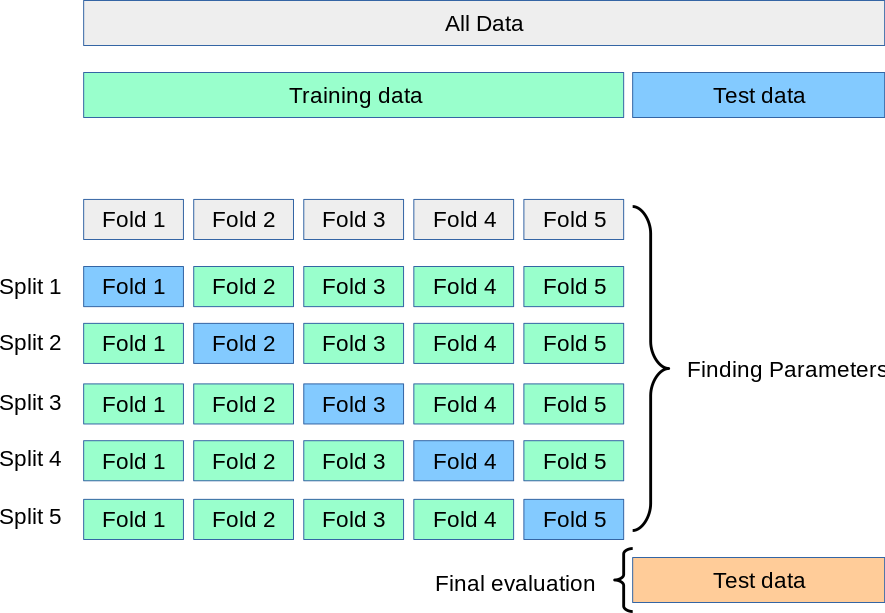

Inicialmente, vamos juntar novamente os dados de treino e validação para compor o conjunto de treino da cross validation

In [18]:
X_train_cv = X_train.append(X_val, ignore_index=True)
X_train_cv.shape

(9203, 14)

In [20]:
y_train_cv = y_train.append(y_val, ignore_index=True)
y_train_cv.shape

(9203,)

Agora, novamente seguindo os passos para otimização com Optuna

In [24]:
def objective_xgb_cv(trial):
  classifier = trial.suggest_categorical("classifier", ["XGB"])
  
  # Passo 2. Definindo conjunto de hiperparâmetros
  xgb_n_estimators = trial.suggest_int("xgb_n_estimators", 750, 1250)
  xgb_learning_rate = trial.suggest_float('xgb_learning_rate', 1e-3, 1e-1, log=True)
  clf = XGBClassifier(
      random_state=RANDOM_STATE, 
      n_estimators=xgb_n_estimators,
      learning_rate=xgb_learning_rate, 
      max_depth=10, # valor mais baixo para prevenir o overfitting
      subsample=0.7, # adicionar randomness
      colsample_bytree=0.7, # adicionar randomness
      max_delta_step=1 # ajuda com datasets desbalanceados
  )
  
  # Passo 3: Métrica otimizada
  scores = cross_val_score(clf, X_train_cv, y_train_cv, cv=5, scoring='f1_weighted')
  return scores.mean()

In [25]:
study_xgb_cv = optuna.create_study(direction="maximize")
study_xgb_cv.optimize(objective_xgb_cv, n_trials=100)

[I 2022-09-05 11:43:40,209] A new study created in memory with name: no-name-f7ba907a-ac09-4eda-8d37-b161e94e65b1
[I 2022-09-05 11:44:51,451] Trial 0 finished with value: 0.8406150187455435 and parameters: {'classifier': 'XGB', 'xgb_n_estimators': 878, 'xgb_learning_rate': 0.028622176554717462}. Best is trial 0 with value: 0.8406150187455435.
[I 2022-09-05 11:46:29,770] Trial 1 finished with value: 0.8091187182611209 and parameters: {'classifier': 'XGB', 'xgb_n_estimators': 1086, 'xgb_learning_rate': 0.003971122542780551}. Best is trial 0 with value: 0.8406150187455435.
[I 2022-09-05 11:48:03,056] Trial 2 finished with value: 0.8444490202167507 and parameters: {'classifier': 'XGB', 'xgb_n_estimators': 1210, 'xgb_learning_rate': 0.03366157489392972}. Best is trial 2 with value: 0.8444490202167507.
[I 2022-09-05 11:49:33,719] Trial 3 finished with value: 0.7975397928562281 and parameters: {'classifier': 'XGB', 'xgb_n_estimators': 1014, 'xgb_learning_rate': 0.002901723059241499}. Best is 

In [26]:
optuna.visualization.plot_optimization_history(study_xgb_cv).show()

In [27]:
print(f"Melhor trial : \n{study_xgb_cv.best_trial}")

print(f"Melhor valor do f-score : \n{study_xgb_cv.best_value}")

print(f"Melhores parâmetros : \n{study_xgb_cv.best_params}")

Melhor trial : 
FrozenTrial(number=64, values=[0.8490712471426693], datetime_start=datetime.datetime(2022, 9, 5, 13, 13, 28, 67756), datetime_complete=datetime.datetime(2022, 9, 5, 13, 14, 44, 6963), params={'classifier': 'XGB', 'xgb_n_estimators': 1209, 'xgb_learning_rate': 0.09923687970094489}, distributions={'classifier': CategoricalDistribution(choices=('XGB',)), 'xgb_n_estimators': IntDistribution(high=1250, log=False, low=750, step=1), 'xgb_learning_rate': FloatDistribution(high=0.1, log=True, low=0.001, step=None)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=64, state=TrialState.COMPLETE, value=None)
Melhor valor do f-score : 
0.8490712471426693
Melhores parâmetros : 
{'classifier': 'XGB', 'xgb_n_estimators': 1209, 'xgb_learning_rate': 0.09923687970094489}


In [37]:
best_xgb_cv = XGBClassifier(
      random_state=RANDOM_STATE, 
      n_estimators=study_xgb_cv.best_params['xgb_n_estimators'], 
      learning_rate=study_xgb_cv.best_params['xgb_learning_rate'], 
      max_depth=10,
      subsample=0.7,
      colsample_bytree=0.7,
      max_delta_step=1
)
cv_scores = cross_val_score(best_xgb_cv, X_train_cv, y_train_cv, cv=5, scoring='f1_weighted')
cv_scores

array([0.85267896, 0.84082377, 0.84869074, 0.860582  , 0.84258077])

In [40]:
best_xgb_cv.fit(X_train_cv, y_train_cv)

XGBClassifier(colsample_bytree=0.7, learning_rate=0.09923687970094489,
              max_delta_step=1, max_depth=10, n_estimators=1209,
              random_state=42, subsample=0.7)

In [41]:
best_clf = best_xgb_cv

Por fim, testamos se o processo de otimização utilizando *cross validation* de fato fez com que o modelo melhorasse seu quadro de overfit

In [42]:
best_clf

XGBClassifier(colsample_bytree=0.7, learning_rate=0.09923687970094489,
              max_delta_step=1, max_depth=10, n_estimators=1209,
              random_state=42, subsample=0.7)

In [43]:
# Treino
y_pred_train = best_clf.predict(X_train_cv)
y_proba_train = best_clf.predict_proba(X_train_cv)
acc_train, auroc_train, f1_train = eval_metrics(y_train_cv, y_pred_train, y_proba_train)
print(f'Accuracy train : {acc_train}')
print(f'AUROC train : {auroc_train}')
print(f'F1-Score train : {f1_train}')

Accuracy train : 1.0
AUROC train : 1.0
F1-Score train : 1.0


In [44]:
# Teste
y_pred_test = best_clf.predict(X_test)
y_proba_test = best_clf.predict_proba(X_test)
acc_test, auroc_test, f1_test = eval_metrics(y_test, y_pred_test, y_proba_test)
print(f'Accuracy test : {acc_test}')
print(f'AUROC test : {auroc_test}')
print(f'F1-Score test : {f1_test}')

Accuracy test : 0.863102998696219
AUROC test : 0.871556721988577
F1-Score test : 0.8432476095744041


Conlusão: o modelo continua num estado de overfit, já que os resultados para treino e teste diferem em aproximadamente 15% em todas as métricas, mesmo após redução de complexidade, inserção de aleatoriedade e uso de cross validation. 